In [12]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
from skimage.transform import resize
from skl2onnx import to_onnx
import onnxruntime as rt
from skimage.feature import hog

%matplotlib inline


In [13]:
def load_image_files(images_dir_path, dimension=(224, 224)):
    images_dir = Path(images_dir_path)
    directories = [directory for directory in images_dir.iterdir()]
    classes = [class_directory.name.lower() for class_directory in directories]

    train_data = []

    for class_index, directory in enumerate(directories):
        for file in directory.iterdir():
            image = imread(file)
            image_resized = resize(image, dimension, anti_aliasing=True, mode='reflect')

            hog_descriptor, hog_image = hog(
                image_resized,
                orientations=8,
                pixels_per_cell=(16, 16),
                cells_per_block=(1, 1),
                visualize=True,
                channel_axis=-1,
            )

            hog_flat = hog_descriptor.flatten()

            train_data.append(
                Bunch(
                    image=image,
                    image_resized=image_resized,
                    hog_image=hog_image,
                    hog_descriptor=hog_descriptor,
                    hog_flat=hog_flat,
                    class_index=class_index,
                    class_name=classes[class_index],
                )
            )

    return train_data

In [14]:
# image_dataset = load_image_files("groceries", dimension=(224, 224))
# img_shape = (224, 224, 3)
# num_classes = 25

image_dataset = load_image_files("cifar-10", dimension=(64, 64))
img_shape = (64, 64, 3)
num_classes = 10

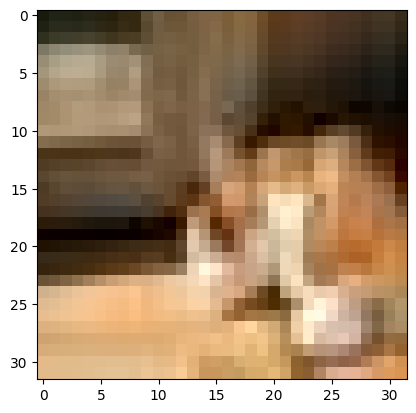

In [15]:
plt.imshow(image_dataset[26].image)
plt.show()

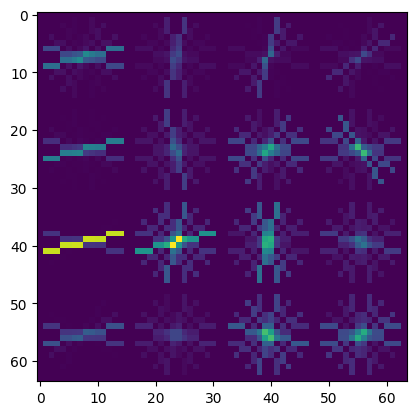

In [16]:
plt.imshow(image_dataset[26].hog_image)
plt.show()

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    list(map(lambda bunch: bunch.hog_descriptor, image_dataset)), 
    list(map(lambda bunch: bunch.class_index, image_dataset)), 
    test_size=0.3,
    random_state=109
)

In [18]:
grid = [
    {
        'C': [1, 10, 100, 1000], 
        'kernel': ['linear']
    },
    {
        'C': [1, 10, 100, 1000], 
        'gamma': [0.001, 0.0001], 
        'kernel': ['rbf']
    },
]

svc = svm.SVC()
svm_classifier = GridSearchCV(svc, grid)
svm_classifier.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

In [19]:
y_pred = svm_classifier.predict(x_test)

In [20]:
print(
    "Classification report for - \n{}:\n{}\n".format(
        svm_classifier, 
        metrics.classification_report(y_test, y_pred)
    )
)

Classification report for - 
GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}]):
              precision    recall  f1-score   support

           0       0.35      0.29      0.32      1500
           1       0.38      0.33      0.35      1489
           2       0.48      0.55      0.51      1493
           3       0.37      0.30      0.33      1493
           4       0.47      0.47      0.47      1490
           5       0.49      0.50      0.50      1472
           6       0.41      0.54      0.46      1492
           7       0.45      0.45      0.45      1561
           8       0.33      0.32      0.33      1542
           9       0.55      0.57      0.56      1468

    accuracy                           0.43     15000
   macro avg       0.43      0.43      0.43     15000
weighted avg       0.43      0.43     

In [21]:
onx = to_onnx(svm_classifier, x_train[0])
# with open("hog_svm_groceries_224_224.onnx", "wb") as f:
with open("hog_svm_cifar10_64_64.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [22]:
session = rt.InferenceSession("hog_svm_cifar10_64_64.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
session.run(None, {input_name: np.array(x_test)[0]})[0][0]

7